In [8]:
!pip install laserembeddings

In [24]:
import pandas as pd
import numpy as np
import laserembeddings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
df = pd.read_csv('gdrive/My Drive/reddit_worldnews_start_to_2016-11-22.csv')[:10000]

df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [12]:
#Now we need to download the pre-trained models
!python -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [13]:
df['score'] = df.up_votes - df.down_votes

df_grouped = df.groupby('author')['title'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped['mean_score'] = df.groupby('author')['score'].mean().values

df_grouped.head()

,author,title,mean_score
0,08ronpaul08,Muslim Black slavery - Islam slave history of ...,0.000000
1,0boy,Canadian says U.S. interrogators threatened ra...,4.416667
2,0drew0,"5 Iraqis after 5 years, how their lives have c...",0.000000
3,100thm0nkey,Mugabe s last stand? Armed police stop opposit...,2.851852
4,1esproc,"Austrian Man, 73, kept daughter in dungeon for...",0.000000


In [0]:
#This will take a while to run!
from laserembeddings import Laser

laser = Laser()

author_vectors = [laser.embed_sentences([text.lower()], lang='en') for text in df_grouped.title]

In [0]:
author_vectors = [np.concatenate(x) for x in author_vectors]

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(author_vectors)

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

In [0]:
df_grouped['tsne_x'] = tsne_results[:,0]
df_grouped['tsne_y'] = tsne_results[:,1]
df_grouped['score_category'] = np.where(df_grouped.mean_score >= np.mean(df_grouped.mean_score) + np.std(df_grouped.mean_score),
                                        'high_scorer',
                                        np.where(df_grouped.mean_score <= np.mean(df_grouped.mean_score) - 10,
                                                 'low_scorer','mid_scorer')
                                        )

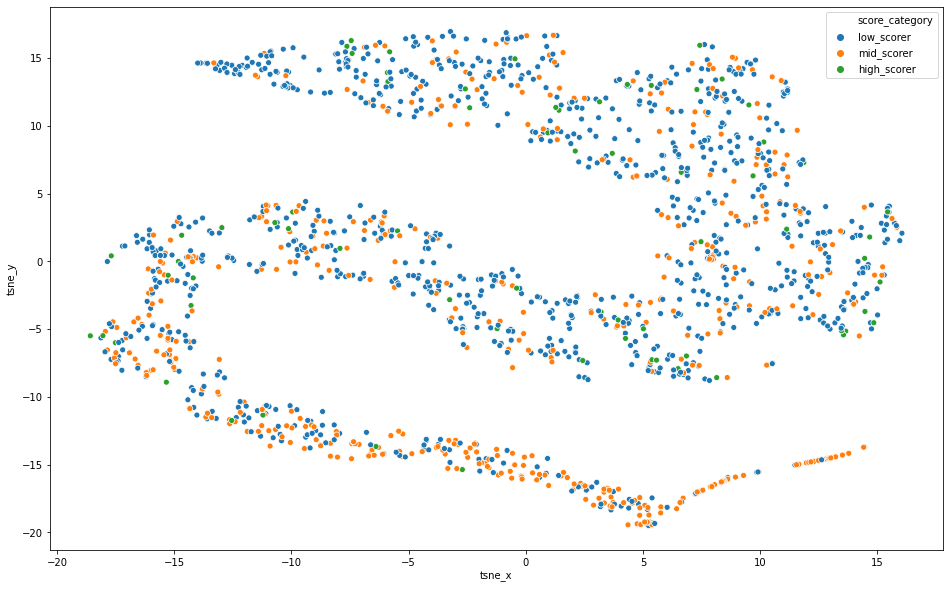

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue="score_category",
    data=df_grouped,
    legend="full")